# Automorphism Ensemble Decoding of Polar Codes

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install numba
!{sys.executable} -m pip install matplotlib

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import ae_decoder
import polar_encoder
import polar_helpers

### Example codes

- Polar(128,60): I_min={27} n=7
- RM(3,7):  I_min={15} n=7
- RM(4,8):  I_min={15} n=8


In [14]:
a_vector = polar_helpers.I_min_to_a_vector(I_min=[27], n=7)

N = a_vector.size
K = np.sum(a_vector)

print(N,K)

print('s =', polar_helpers.get_stabilizer_block_profile(a_vector))

128 60
s = [3, 4]


In [15]:
M = 8 # ensemble size

encoder = polar_encoder.Polar_Encoder(a_vector)
decoder = ae_decoder.AE_SC_Decoder(a_vector,M=M, minsum=True)

In [16]:
target_block_errors = 250

EbN0_values_dB = np.linspace(0,3.5,8)

bler = np.zeros_like(EbN0_values_dB)
ber = np.zeros_like(EbN0_values_dB)

R = K/N

for i, EbN0_dB in enumerate(EbN0_values_dB):
    np.random.seed(0)
    noise_variance = 1/(2*R*10**(EbN0_dB/10))
    std = np.sqrt(noise_variance)
    
    frame_counter = 0
    block_errors = 0
    bit_errors = 0
    
    while block_errors < target_block_errors:
        u = np.random.randint(0,2,K)
        c = encoder.encode(u)
        x = 1-2*c.astype(np.float32)
        y = x + std*np.random.randn(N)
        llrs = 2*y/noise_variance
        c_hat, u_hat = decoder.decode(llrs)
        
        bit_errors += np.sum(u != u_hat)
        frame_counter += 1
        if np.any(c_hat != c):
            block_errors += 1
            ber_est = bit_errors/(frame_counter*K)
            bler_est = block_errors/frame_counter
            print("Eb/N0 = %.1f dB: %4d / %4d, BLER = %.3e, BER = %.3e\r"%(EbN0_dB, block_errors, target_block_errors, bler_est, ber_est),end='',flush=True)
            
        
        
    ber[i] = bit_errors/(frame_counter*K)
    bler[i] = block_errors/frame_counter
    print()
    
    

Eb/N0 = 0.0 dB:  250 /  250, BLER = 5.721e-01, BER = 2.260e-01
Eb/N0 = 0.5 dB:  250 /  250, BLER = 4.019e-01, BER = 1.471e-01
Eb/N0 = 1.0 dB:  250 /  250, BLER = 2.191e-01, BER = 7.622e-02
Eb/N0 = 1.5 dB:  250 /  250, BLER = 1.028e-01, BER = 3.541e-02
Eb/N0 = 2.0 dB:  250 /  250, BLER = 3.413e-02, BER = 1.205e-02
Eb/N0 = 2.5 dB:  250 /  250, BLER = 9.893e-03, BER = 3.257e-03
Eb/N0 = 3.0 dB:  250 /  250, BLER = 2.186e-03, BER = 6.841e-04
Eb/N0 = 3.5 dB:  250 /  250, BLER = 3.488e-04, BER = 1.049e-04


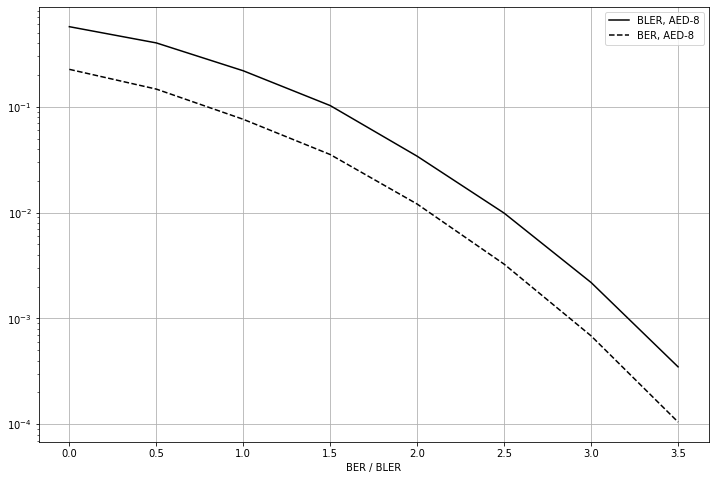

In [17]:
plt.figure(figsize=(12,8))
plt.semilogy()
plt.plot(EbN0_values_dB, bler, color='k', linestyle="-", label="BLER, AED-%d"%M)
plt.plot(EbN0_values_dB, ber, color='k', linestyle="--", label="BER, AED-%d"%M)
plt.grid()
plt.legend()
plt.xlabel("Eb/N0 in dB")
plt.xlabel("BER / BLER")
plt.show()